In [43]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from glob import glob
import numpy as np
import matplotlib
import seaborn as sns
import PIL
PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sys
import json
import pandas as pd
import cvlib as cv
from cvlib.object_detection import draw_bbox
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_datasets as tfds

In [44]:
import pathlib

In [45]:
dataset_path = 'C:/Users/kangminju/Documents/DL_ws/원천_Training_통제환경분류'

In [78]:
batch_size = 32
img_height = 80
img_width = 50

In [79]:
train_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    color_mode = 'grayscale',
    batch_size=batch_size
)

Found 100303 files belonging to 5 classes.
Using 80243 files for training.


In [80]:
val_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    color_mode = 'grayscale',
    batch_size=batch_size
)

Found 100303 files belonging to 5 classes.
Using 20060 files for validation.


In [81]:
class_names = train_x.class_names
print(class_names)

['정상주시', '졸음재현', '통화재현', '하품재현', '흡연재현']


In [82]:
import platform
import seaborn as sns
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system. sorry")

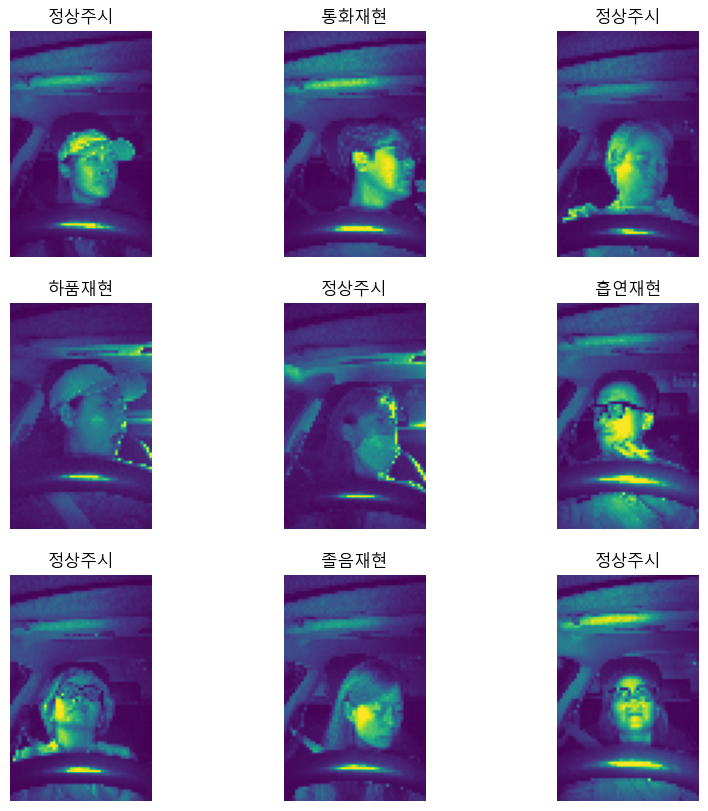

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_x.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [84]:
for image_batch, labels_batch in train_x:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 50, 1)
(32,)


In [53]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [54]:
normalized_x = train_x.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_x))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.023920342 0.99393576


## vggnet 사용

In [55]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax'),
  tf.keras.layers.Dense(num_classes)
])

In [56]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [57]:
hist = model.fit(
  train_x,
  validation_data=val_x,
  epochs=3
)

Epoch 1/3
2508/2508 [==============================] - 3735s 1s/step - loss: 1.8265 - accuracy: 0.1390 - val_loss: 1.6094 - val_accuracy: 0.1092
Epoch 2/3
2508/2508 [==============================] - 3696s 1s/step - loss: 1.6094 - accuracy: 0.1111 - val_loss: 1.6094 - val_accuracy: 0.1092
Epoch 3/3
2508/2508 [==============================] - 3687s 1s/step - loss: 1.6094 - accuracy: 0.1111 - val_loss: 1.6094 - val_accuracy: 0.1092


In [58]:
hist.history

{'loss': [1.8264803886413574, 1.6094214916229248, 1.6094214916229248],
 'accuracy': [0.1389653980731964, 0.11105018854141235, 0.11105018854141235],
 'val_loss': [1.6094361543655396, 1.6094361543655396, 1.6094361543655396],
 'val_accuracy': [0.10922233015298843,
  0.10922233015298843,
  0.10922233015298843]}

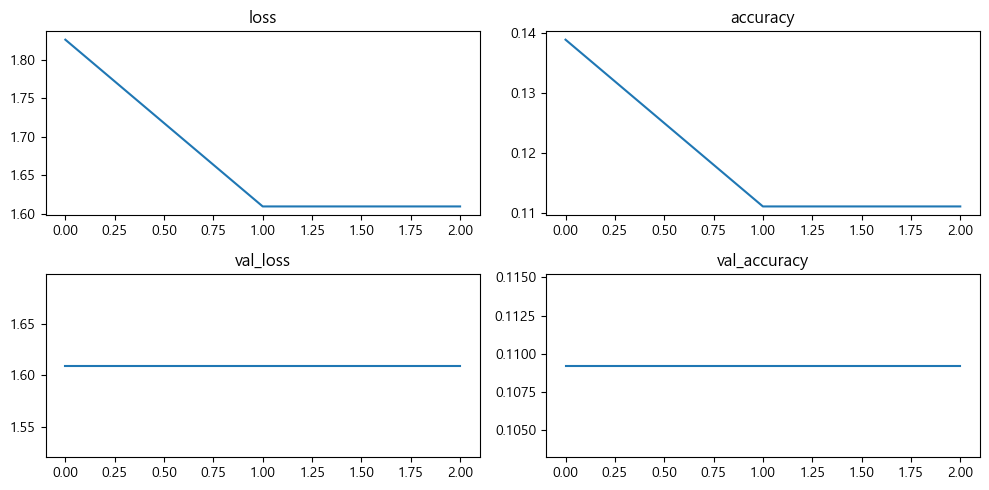

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

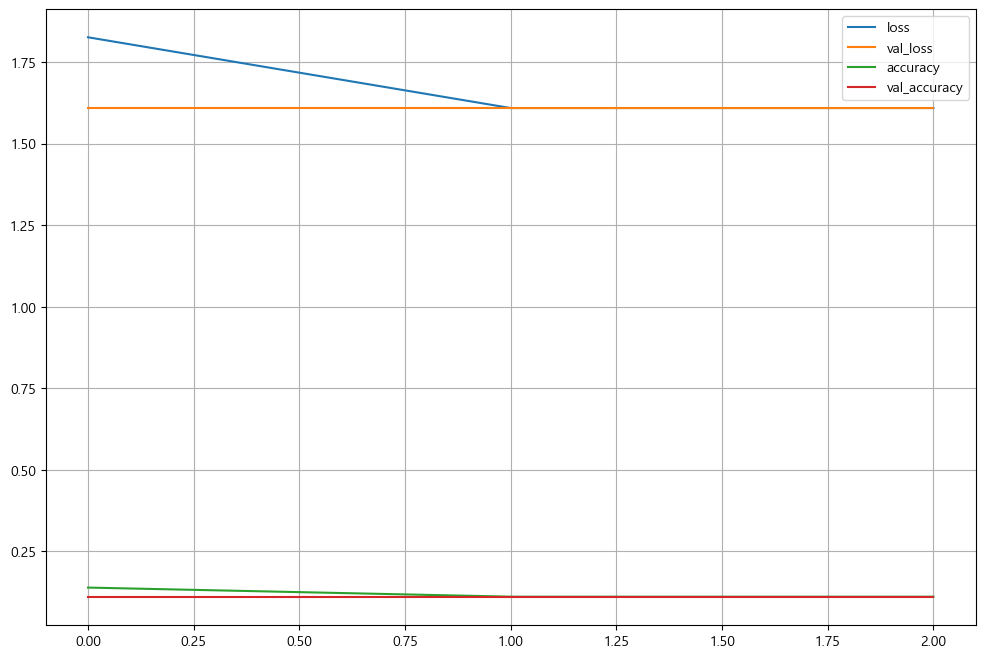

In [60]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [61]:
score = model.evaluate(train_x)
score

2508/2508 [==============================] - 1073s 428ms/step - loss: 1.6094 - accuracy: 0.1111


[1.6094214916229248, 0.11105018854141235]

## resnet 사용

In [62]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [63]:
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(5, activation='softmax')(net)

    model2 = tf.keras.Model(inputs=inputs, outputs=net)

    return model2

In [64]:
model2 = build_resnet((180,180,3))

In [65]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 90, 90, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 45, 45, 32)  0           ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 45, 45, 64)   2112        ['max_pooling2d_8[0][0]']    

In [66]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [67]:
hist2 = model2.fit(
  train_x,
  validation_data=val_x,
  epochs=3)

Epoch 1/3
2508/2508 [==============================] - 1647s 656ms/step - loss: 2.5501 - accuracy: 0.5244 - val_loss: 0.9734 - val_accuracy: 0.5884
Epoch 2/3
2508/2508 [==============================] - 1653s 659ms/step - loss: 0.9244 - accuracy: 0.6106 - val_loss: 0.9714 - val_accuracy: 0.5901
Epoch 3/3
2508/2508 [==============================] - 1692s 675ms/step - loss: 0.8487 - accuracy: 0.6424 - val_loss: 0.8940 - val_accuracy: 0.6235


In [68]:
hist2.history

{'loss': [2.55010724067688, 0.9244281053543091, 0.8487377762794495],
 'accuracy': [0.5243946313858032, 0.6105579137802124, 0.6424111723899841],
 'val_loss': [0.9734150171279907, 0.9714027643203735, 0.8939510583877563],
 'val_accuracy': [0.5883848667144775, 0.5901296138763428, 0.6235294342041016]}

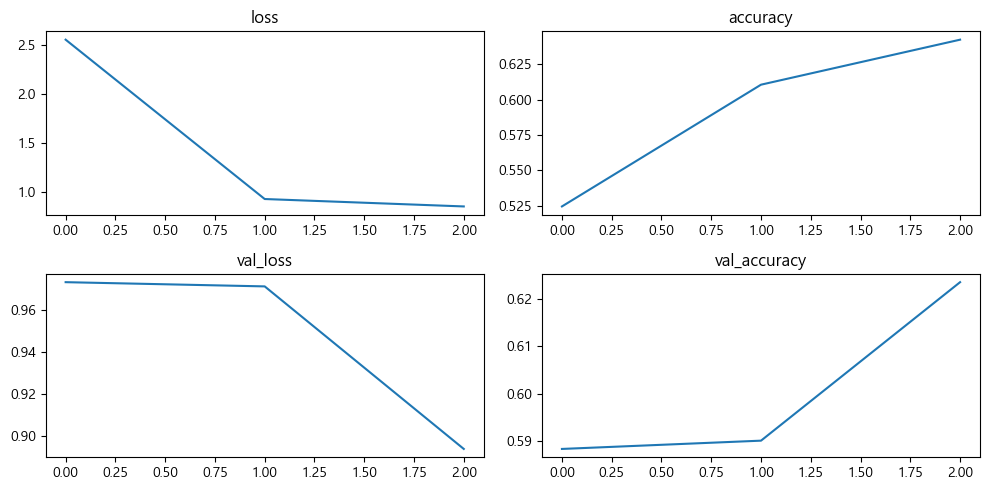

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist2.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist2.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist2.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist2.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

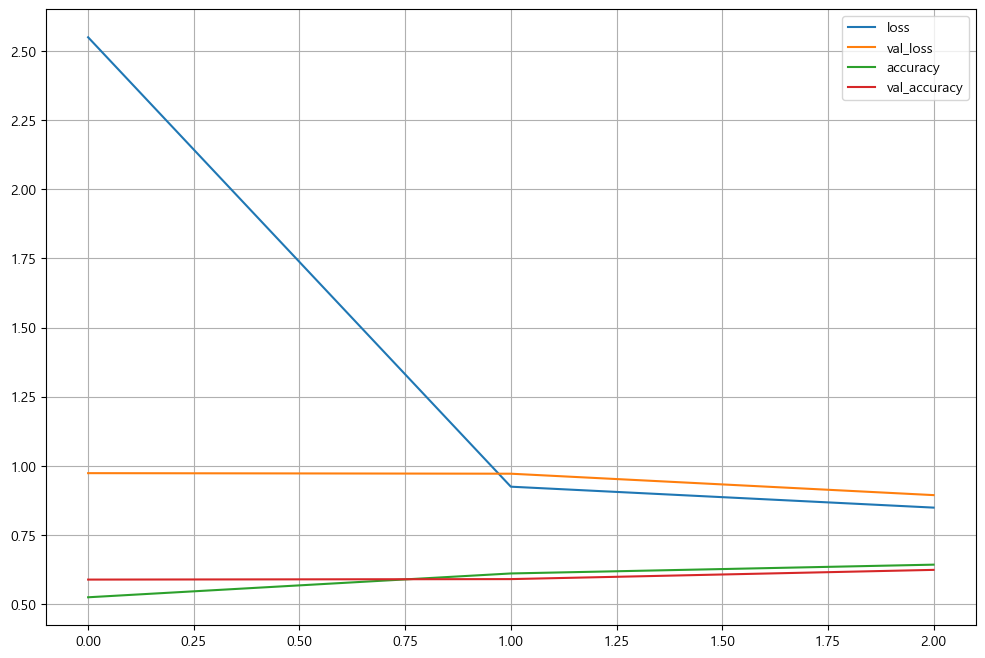

In [70]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist2.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [71]:
score2 = model2.evaluate(val_x)
score2

627/627 [==============================] - 139s 221ms/step - loss: 0.8940 - accuracy: 0.6235


[0.8939505815505981, 0.6235294342041016]